<a href="https://colab.research.google.com/github/ilanouk/Data-Science/blob/main/Evaluating_Classification_Models_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Usually Python packages
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Packages for evaluation metrics
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# A supervised model: Logistic Regression
from sklearn.linear_model import LogisticRegression

%matplotlib inline

## Load the data and fit the model

In [ ]:
# The data will be saved in the 'sample_data' directory
DATA_DIR_PATH = "./sample_data"
DATA_DIR_PATH

'./sample_data'

### Load loan data

In [ ]:
# Load the data using 'read_csv'
MY_DATA = 'loan_data.csv'
loan_data = pd.read_csv(os.path.join(DATA_DIR_PATH, MY_DATA))
print(loan_data.shape); loan_data.head()

(45342, 21)


,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


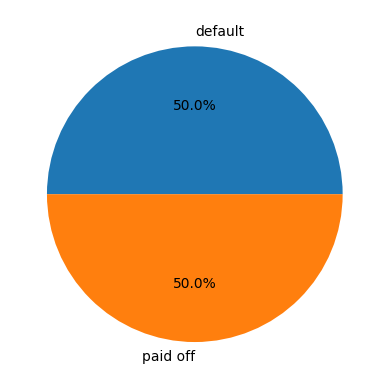

In [ ]:
# Put the ground truth in 'y'
y = loan_data['outcome'] # .cat.categories
y_count = y.value_counts()

# Let's visualize the class imbalance
fig, ax = plt.subplots()
ax.pie(y_count, labels = ['default', 'paid off'], autopct='%1.1f%%');

### Logistic regression

In [ ]:
# The LR model relies on several variables (predictors) to predict a
# response (outcome).
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

# Categorical variables should be dummified, ie. turned into binary variables
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', drop_first=True)

# Split the data into train and tests datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

# Set the model parameters and fit the model
logit_reg = LogisticRegression(penalty='l2', solver='liblinear')
logit_reg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [ ]:
print("intercept  {:10.4f}".format(logit_reg.intercept_[0]))
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns)

intercept     -1.6289
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079964
borrower_score,4.524884
debt_consolidation,-0.243201
home_improvement,-0.373315
major_purchase,-0.228300
medical,-0.535350
other,-0.632758
small_business,-1.230888
OWN,-0.053935
RENT,-0.145208


## Confusion matrix and evaluation metrics

The confusion matrix is a table showing the number of correct and incorrect predictions categorized by type of response. In the following, we will consider a *logistic regression* model that was trained on a balanced data set with an equal number of defaulted and paid-off loans.<br>

**Convention** Y=1 corresponds to the event of interest and Y = 0 corresponds to a negative (or usual) event.



In [ ]:
# Make predictions on the test dataset
y_test_pred = logit_reg.predict(X_test)

# Obtain the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
cm
# TN -> C0,0 (default, default)
# FN -> C1,0 (paid off, default)
# TP -> C1,1 (paid off, paid off)
# FP -> C0,1 (default, paid off)

array([[2870, 1623],
       [1672, 2904]])

In [ ]:
conf_mat = pd.DataFrame([[cm[0, 0], cm[0, 1]],
                         [cm[1, 0], cm[1, 1]]],
                       index=['Y = default', 'Y = paid off'],
                       columns=['Yhat = default', 'Yhat = paid off'])
print(conf_mat)

              Yhat = default  Yhat = paid off
Y = default             2870             1623
Y = paid off            1672             2904


In [ ]:
# NB: .predict() is the binarized version of .predict_prob()
print(logit_reg.predict(X_test))
print(logit_reg.predict_proba(X_test))

# --> by default, the threshold is at 0.5
# --> the class with the strongest proba is the predicted one

['default' 'paid off' 'paid off' ... 'paid off' 'paid off' 'default']
[[0.83791535 0.16208465]
 [0.30348366 0.69651634]
 [0.33337076 0.66662924]
 ...
 [0.4257403  0.5742597 ]
 [0.33857211 0.66142789]
 [0.50353292 0.49646708]]


In [ ]:
# We could set a threshold at 0.4
y_test_pred_04 = ['default' if x >= 0.4 else 'paid off' for x in logit_reg.predict_proba(X_test)[:,1]]

# Obtain the confusion matrix
cm_04 = confusion_matrix(y_test, y_test_pred_04)
print(cm_04)

[[2607 1886]
 [3760  816]]


In [ ]:
# Or, we could set a threshold at 0.7
y_test_pred_07 = ['default' if x >= 0.7 else 'paid off' for x in logit_reg.predict_proba(X_test)[:,1]]

# Obtain the confusion matrix
cm_07 = confusion_matrix(y_test, y_test_pred_07)
print(cm_07)

[[ 244 4249]
 [ 870 3706]]


### Precision, Recall, and Specificity
The _scikit-learn_ function `precision_recall_fscore_support` returns
precision, recall, f_score and support.

#### With threshold at 0.5

In [ ]:
# With threshold at 0.5
print('Precision\t{:.4f}'.format(cm[1, 1] / sum(cm[:, 1])))
print('Recall\t{:.4f}'.format(cm[1, 1] / sum(cm[1, :])))
print('Specificity\t{:.4f}'.format(cm[0, 0] / sum(cm[0, :])))

# NB:
# TFP = 1 - Specificity = 1 - (TN/(TN+FP))
# Specificity = 1 - TFP

Precision	0.6415
Recall	0.6346
Specificity	0.6388


In [ ]:
precision_recall_fscore_support(y_test, y_test_pred,
                                labels=['default', 'paid off'])

(array([0.63188023, 0.64148443]),
 array([0.63877142, 0.63461538]),
 array([0.63530714, 0.63803142]),
 array([4493, 4576]))

#### With threshold at 0.4

In [ ]:
print('Precision\t{:.4f}'.format(cm_04[1, 1] / sum(cm_04[:, 1])))
print('Recall\t{:.4f}'.format(cm_04[1, 1] / sum(cm_04[1, :])))
print('Specificity\t{:.4f}'.format(cm_04[0, 0] / sum(cm_04[0, :])))

Precision	0.3020
Recall	0.1783
Specificity	0.5802


#### With threshold at 0.7

In [ ]:
print('Precision\t{:.4f}'.format(cm_07[1, 1] / sum(cm_07[:, 1])))
print('Recall\t{:.4f}'.format(cm_07[1, 1] / sum(cm_07[1, :])))
print('Specificity\t{:.4f}'.format(cm_07[0, 0] / sum(cm_07[0, :])))

Precision	0.4659
Recall	0.8099
Specificity	0.0543


### ROC Curve
The function `roc_curve` in _Scikit-learn_ calculates all the information that is required for plotting a ROC curve.

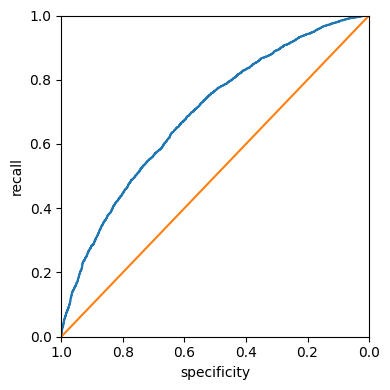

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, logit_reg.predict_proba(X_test)[:, 0], pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')


plt.tight_layout()
plt.show()

### AUC
Accuracy can easily be calculated using the _scikit-learn_ function `accuracy_score`.

In [ ]:
print(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)))
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y_test], logit_reg.predict_proba(X_test)[:, 0]))

0.692365717689833
0.692365839285353


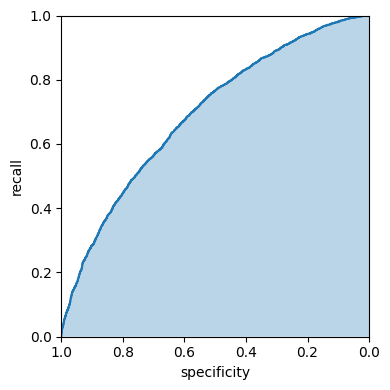

In [ ]:
%matplotlib inline
fpr, tpr, thresholds = roc_curve(y_test, logit_reg.predict_proba(X_test)[:,0], pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
# ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()

## Cross validation

Objective: Perform model tuning with the end goal to choose a model which<br/>
has a high generalization performance.

You can refer to the scikit-learn documentation for full details.
[link text](https://scikit-learn.org/stable/modules/cross_validation.html)

The following is done in this technique for training, validating, and testing the model:


1.   The dataset is split into training and test dataset.
2.   The training dataset is then split into K-folds.

> Indented block
3.   Out of the K-folds, (K-1) fold is used for training
4.   1 fold is used for validation
5.   The model with specific hyperparameters is trained with training data (K-1 folds) and validation data as 1 fold. The performance of the model is recorded.

> Indented block
6.   The above steps (**step 3**, **step 4**, and **step 5**) is repeated until each of the k-fold got used for validation purpose. This is why it is called k-fold cross-validation.
7.   Finally, the mean and standard deviation of the model performance is computed by taking all of the model scores calculated in step 5 for each of the K models.

8.   **Step 3 to Step 7** is repeated for different values of hyperparameters.

9.   Finally, the hyperparameters which result in the most optimal mean and the standard deviation of model scores get selected.

10.   The model is then trained **using the entire training data set** (**step 2**) and **the model performance is computed on the test data set** (**step 1**).



### Estimate the accuracy of a linear kernel support vector machine

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn import svm

# Get the iris data
X, y = load_iris(return_X_y=True)

# We set a SVM classifier
clf = svm.SVC(kernel = 'linear', C = 1, random_state = 42)

# We fit the SVM on 5 folds
scores = cross_val_score(clf, X, y, cv = 5)
scores

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

In [ ]:
# The mean score and the standard deviation are hence given by
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.98 accuracy with a standard deviation of 0.02


### Multiple metric evaluation

We consider here the **cross_validate()** function, which differs from **cross_val_score()** in two ways:


*   It allows specifying multiple metrics for evaluation.
*   It returns a dict containing fit-times, score-times (and optionally training scores, fitted estimators, train-test split indices) in addition to the test score.



In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn import svm

In [ ]:
# Set the list of required metrics
scoring = ['precision_macro', 'recall_macro']

# Choose a classifier (SVM) and set the hyperparameters
clf = svm.SVC(kernel='linear', C=1, random_state=0)

In [ ]:
# Fit and text the model with cross-validation
scores = cross_validate(clf, X, y, scoring=scoring)

In [ ]:
sorted(scores.keys())

['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']

In [ ]:
scores['test_recall_macro']

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

## Tuning the hyper-parameters of an estimator

I recommand the reading of [this scikit-learn documention](https://scikit-learn.org/stable/modules/grid_search.html#) to go deeper into the
grid search and the cross-validation approaches for hyperparameters tuning.
